In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np  # linear algebra
import os
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu

In [ ]:
# !unzip -u "/content/drive/Shareddrives/cse 455/CatBreed.zip" -d "/content/drive/Shareddrives/cse 455/"

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
# rm -rf "/content/drive/Shareddrives/cse 455/CatBreed_restructured"

In [ ]:
# mkdir "/content/drive/Shareddrives/cse 455/CatBreed_restructured"

In [ ]:
# restructure data 
import os
import shutil

# Define the paths to the folders
data_folder = "/content/drive/Shareddrives/cse 455/cats-breads"
train_folder = "/content/drive/Shareddrives/cse 455/CatBreed_restructured/train/"
test_folder = "/content/drive/Shareddrives/cse 455/CatBreed_restructured/test/"
valid_folder = "/content/drive/Shareddrives/cse 455/CatBreed_restructured/valid/"

# Create the train, test, and valid folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)

# ignore_folder = ["Domestic Short Hair", "Domestic Long Hair", "Domestic Medium Hair", 
#                  "American Bobtail", "American Shorthair", "American Wirehair", "American Curl"]

# Loop through each breed folder in the data folder
for breed_folder_name in tqdm(os.listdir(data_folder)):
    if breed_folder_name == '.DS_Store' : # breed_folder_name in ignore_folder
      print("ignored: " + breed_folder_name)
      continue
    breed_folder_path = os.path.join(data_folder, breed_folder_name)
    # Get a list of all the image files in the breed folder
    image_file_names = os.listdir(breed_folder_path)
    image_file_names.sort() # Sorting the files to get consistent files for each folder
    if len(image_file_names) < 50:
      continue

    # Create the corresponding breed folder in the train, test, and valid folders
    train_breed_folder_path = os.path.join(train_folder, breed_folder_name)
    os.makedirs(train_breed_folder_path, exist_ok=True)
    
    test_breed_folder_path = os.path.join(test_folder, breed_folder_name)
    os.makedirs(test_breed_folder_path, exist_ok=True)
    
    valid_breed_folder_path = os.path.join(valid_folder, breed_folder_name)
    os.makedirs(valid_breed_folder_path, exist_ok=True)
    

    # Split the image files into train, test, and valid sets
    test_image_file_names = image_file_names[:int(len(image_file_names) * 0.1)]
    valid_image_file_names = image_file_names[-int(len(image_file_names) * 0.1):]
    train_image_file_names = image_file_names[int(len(image_file_names) * 0.1):-int(len(image_file_names) * 0.1)]

    # Move the image files into the corresponding train, test, and valid breed folders
    for image_file_name in test_image_file_names:
        if image_file_name == '.DS_Store':
          continue
        src_path = os.path.join(breed_folder_path, image_file_name)
        dst_path = os.path.join(test_breed_folder_path, image_file_name)
        shutil.copy(src_path, dst_path)

    for image_file_name in valid_image_file_names:
        if image_file_name == '.DS_Store':
          continue
        src_path = os.path.join(breed_folder_path, image_file_name)
        dst_path = os.path.join(valid_breed_folder_path, image_file_name)
        shutil.copy(src_path, dst_path)

    for image_file_name in train_image_file_names:
        if image_file_name == '.DS_Store':
          continue
        src_path = os.path.join(breed_folder_path, image_file_name)
        dst_path = os.path.join(train_breed_folder_path, image_file_name)
        shutil.copy(src_path, dst_path)


100%|██████████| 12/12 [01:10<00:00,  5.86s/it]


# Load Data

In [ ]:
import os
import pickle
breeds = os.listdir("/content/drive/Shareddrives/cse 455/CatBreed_restructured/test")
breeds = sorted(breeds)
idx_to_name = dict() 
name_to_idx = dict()

for i in range(len(breeds)):
    idx_to_name[i] = breeds[i]
name_to_idx = {value: key for key, value in idx_to_name.items()}

(idx_to_name, name_to_idx)

# with open("/content/drive/Shareddrives/cse 455/CatBreed_models/cat_class_to_name", "wb") as f:
#     pickle.dump(idx_to_name, f)

({0: 'Abyssinian',
  1: 'Bengal',
  2: 'Birman',
  3: 'Bombay',
  4: 'British_Shorthair',
  5: 'Egyptian_Mau',
  6: 'Maine_Coon',
  7: 'Persian',
  8: 'Ragdoll',
  9: 'Russian_Blue',
  10: 'Siamese',
  11: 'Sphynx'},
 {'Abyssinian': 0,
  'Bengal': 1,
  'Birman': 2,
  'Bombay': 3,
  'British_Shorthair': 4,
  'Egyptian_Mau': 5,
  'Maine_Coon': 6,
  'Persian': 7,
  'Ragdoll': 8,
  'Russian_Blue': 9,
  'Siamese': 10,
  'Sphynx': 11})

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
DATA_PATH = "/content/drive/Shareddrives/cse 455/CatBreed_restructured/"
BATCH_SIZE = 32
SAVE_TO = "/content/drive/Shareddrives/cse 455/CatBreed_models/"

In [ ]:
## add data augmentation
transform_train = transforms.Compose([
transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
transforms.RandomCrop(IMAGE_WIDTH, padding=8, padding_mode='edge'), # Take IMAGE_WIDTHxIMAGE_WIDTH crops from padded images
transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
transforms.ToTensor(),
transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
])


transform_test = transforms.Compose([
transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
transforms.ToTensor(),
transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
])


In [ ]:
#  rmdir "/content/drive/Shareddrives/cse 455/CatBreed_restructured/test/.ipynb_checkpoints"

In [ ]:
data_train = datasets.ImageFolder(DATA_PATH + "train", transform=transform_train)
data_test = datasets.ImageFolder(DATA_PATH + "test", transform=transform_test)
data_val = datasets.ImageFolder(DATA_PATH + "valid", transform=transform_test)


In [ ]:
train_loader = DataLoader(
data_train,
batch_size=BATCH_SIZE,
shuffle=True,
num_workers=2
)

val_loader = DataLoader(
data_val,
batch_size=BATCH_SIZE,
shuffle=False,
num_workers=2

)

test_loader = DataLoader(
data_test,
batch_size=BATCH_SIZE,
shuffle=False,
num_workers=2
)

In [ ]:
(len(data_train), len(data_test), len(data_val))


(1806, 230, 227)

In [ ]:
from collections import Counter
print(dict(Counter(data_train.targets)))

{0: 163, 1: 160, 2: 135, 3: 160, 4: 160, 5: 127, 6: 160, 7: 160, 8: 152, 9: 160, 10: 160, 11: 109}


torch.Size([30, 3, 224, 224])


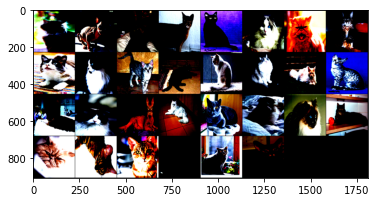

Labels:Maine_Coon
Labels:Sphynx
Labels:Bombay
Labels:Abyssinian
Labels:Bombay
Labels:Ragdoll
Labels:Persian
Labels:Maine_Coon
Labels:Ragdoll
Labels:Ragdoll
Labels:Egyptian_Mau
Labels:Bombay
Labels:Ragdoll
Labels:Ragdoll
Labels:Maine_Coon
Labels:Egyptian_Mau
Labels:Abyssinian
Labels:Ragdoll
Labels:Abyssinian
Labels:Persian
Labels:British_Shorthair
Labels:Ragdoll
Labels:Ragdoll
Labels:Maine_Coon
Labels:Persian
Labels:Bengal
Labels:Bengal
Labels:Abyssinian
Labels:British_Shorthair
Labels:Abyssinian


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:30]
labels = labels[:30]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
for label in labels:
  print("Labels:" + idx_to_name[label.item()])

# Define Model

In [ ]:

def train(net, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, state=None, schedule={}):
    net.to(DEVICE)
    net.train()
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    val_losses = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        train_losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0
        train_acc = 0.0
        net.train()

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        loop = tqdm(enumerate(train_loader), total = len(train_loader))
        for i, batch in loop:
          inputs, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)

          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          labels_pred_max = torch.argmax(outputs, 1)
          batch_acc = torch.sum(labels_pred_max == labels)
          train_acc = train_acc + batch_acc.item()
          loss.backward()  # autograd magic, computes all the partial derivatives
          optimizer.step() # takes a step in gradient direction

          train_losses.append(loss.item())
          sum_loss += loss.item()
          loop.set_postfix(batch_idx= i, batch_acc= batch_acc.item() /BATCH_SIZE, loss= loss.item())

        # Validation loop; use .no_grad() context manager to save memory.
        train_losses.append(sum_loss / len(train_loader))
        train_accuracies.append(train_acc / (BATCH_SIZE * len(train_loader)))
        net.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
          for (v_batch, labels) in val_loader:
              v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
              labels_pred = net(v_batch)
              v_batch_loss = criterion(labels_pred, labels)
              val_loss = val_loss + v_batch_loss.item()
              v_pred_max = torch.argmax(labels_pred, 1)
              batch_acc = torch.sum(v_pred_max == labels)
              val_acc = val_acc + batch_acc.item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc / (BATCH_SIZE * len(val_loader)))
        print("Epoch: {}, val loss: {:.4f}, val acc: {:.4f}, train loss: {:.4f}, train acc: {:.4f},\n".format(
            epoch, val_losses[epoch], val_accuracies[epoch], train_losses[epoch], train_accuracies[epoch]))

        torch.save(net.state_dict(), SAVE_TO+"CatBreed_ckpt" +  str(epoch)+ ".pt")
    return losses

In [ ]:
# resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
# resnet.fc = nn.Linear(512, 40) # This will reinitialize the layer as well

# losses = train(resnet, epochs=5, lr=.01 )

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 12) # This will reinitialize the layer as well
losses = train(resnet, epochs=20,  lr=.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 57/57 [00:16<00:00,  3.45it/s, batch_acc=0.312, batch_idx=56, loss=1.07]


Epoch: 0, val loss: 0.7986, val acc: 0.7383, train loss: 2.6541, train acc: 0.4841,



100%|██████████| 57/57 [00:16<00:00,  3.46it/s, batch_acc=0.375, batch_idx=56, loss=0.464]


Epoch: 1, val loss: 0.4493, val acc: 0.7656, train loss: 2.7148, train acc: 0.8388,



100%|██████████| 57/57 [00:18<00:00,  3.11it/s, batch_acc=0.344, batch_idx=56, loss=0.604]


Epoch: 2, val loss: 0.3428, val acc: 0.7969, train loss: 2.6481, train acc: 0.8865,



100%|██████████| 57/57 [00:16<00:00,  3.40it/s, batch_acc=0.406, batch_idx=56, loss=0.313]


Epoch: 3, val loss: 0.3028, val acc: 0.8047, train loss: 2.5219, train acc: 0.9046,



100%|██████████| 57/57 [00:17<00:00,  3.23it/s, batch_acc=0.406, batch_idx=56, loss=0.228]


Epoch: 4, val loss: 0.2712, val acc: 0.7930, train loss: 2.5745, train acc: 0.9243,



100%|██████████| 57/57 [00:18<00:00,  3.11it/s, batch_acc=0.438, batch_idx=56, loss=0.176]


Epoch: 5, val loss: 0.2617, val acc: 0.8008, train loss: 2.6920, train acc: 0.9353,



100%|██████████| 57/57 [00:16<00:00,  3.40it/s, batch_acc=0.406, batch_idx=56, loss=0.265]


Epoch: 6, val loss: 0.2546, val acc: 0.8086, train loss: 2.2666, train acc: 0.9430,



100%|██████████| 57/57 [00:16<00:00,  3.43it/s, batch_acc=0.406, batch_idx=56, loss=0.213]


Epoch: 7, val loss: 0.2642, val acc: 0.8086, train loss: 2.4342, train acc: 0.9529,



 46%|████▌     | 26/57 [00:08<00:10,  3.00it/s, batch_acc=0.969, batch_idx=25, loss=0.124]


KeyboardInterrupt: ignored

In [ ]:
def evaluate(model:  nn.Module, dataloader):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for  (batch, labels) in tqdm(dataloader):
          images, labels = batch.to(DEVICE), labels.to(DEVICE)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, dim = 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [ ]:
resnet.load_state_dict(torch.load('/content/drive/Shareddrives/cse 455/CatBreed_models/CatBreed_ckpt6.pt'))

test_acc = evaluate(resnet, test_loader)
print(f"\n Test Accuracy: {test_acc}")

100%|██████████| 8/8 [00:01<00:00,  4.30it/s]


 Test Accuracy: 0.9304347826086956
